### Imports

In [1]:
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
from itertools import chain
import torch
import torchvision as tv
import numpy as np
import torch.nn as nn
import torch.optim as om
import torch.nn.functional as F
import time
import pandas as pd

# Make sure GPU is available
if torch.cuda.is_available():     
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")
    
np.random.seed(551)


### Récupération des données

In [3]:
#Set all_data on False for working with reduced data
all_data = True
samples = 5000

data_dir = 'resized'              
repertories = os.listdir(data_dir)
nested_list  = []
labels = []

#Create a nested_list
for index, rep_name in enumerate(repertories) :
    file_names = os.listdir(os.path.join(data_dir, rep_name))
    file_names = [data_dir + '/' + rep_name + '/'+ file for file in file_names]
    if not all_data :
        file_names = random.sample(file_names, samples)
    labels.append([index for file in file_names])
    nested_list.append(file_names)
    
#Create an unested list 
unested_list = list(chain.from_iterable(nested_list))
labels = list(chain.from_iterable(labels))

# The dimensions of each image
imageWidth, imageHeight = Image.open(unested_list[0]).size         

print("There are", len(unested_list), "images in", len(repertories),"distinct categories")
print("Label names: " + ' - '.join(repertories))
print("Numbers by label: " + ' - '.join([str(len(files)) for files in nested_list]))
print("Image dimensions:", imageWidth, "x", imageHeight)

There are 58954 images in 6 distinct categories
Label names: AbdomenCT - BreastMRI - ChestCT - CXR - Hand - HeadCT
Numbers by label: 10000 - 8954 - 10000 - 10000 - 10000 - 10000
Image dimensions: 64 x 64


### Visualisation aléatoires des images

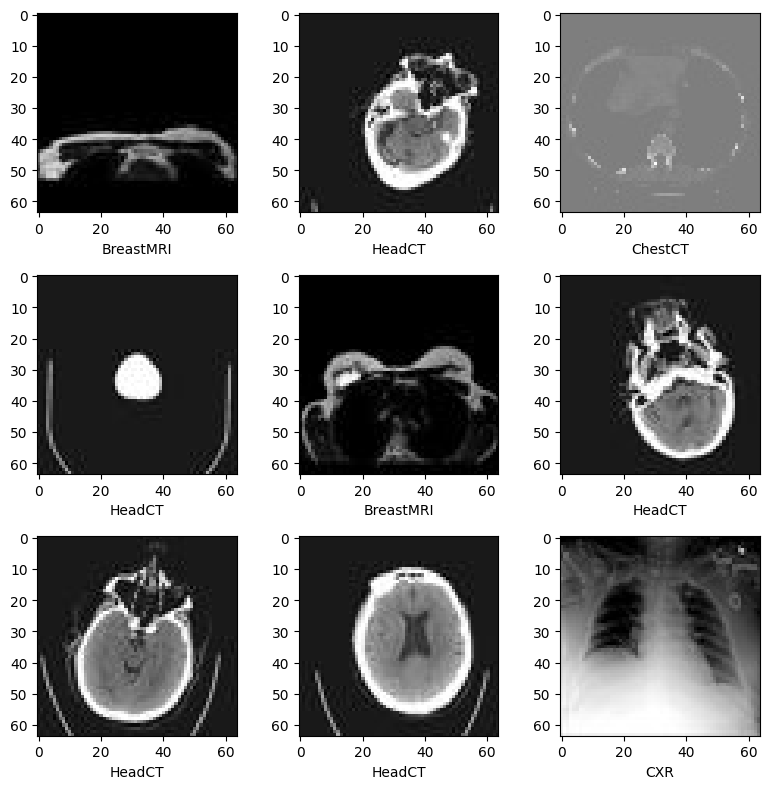

In [4]:
# Take a random sample of 9 images and plot with label
plt.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(len(unested_list), size=9)):  
    im = Image.open(unested_list[k])                          
    arr = np.array(im)
    plt.subplot(3,3,i+1)
    plt.xlabel(repertories[labels[k]])
    plt.imshow(arr,cmap='gray',vmin=0,vmax=255)
plt.tight_layout()
plt.show()

### Création de tenseurs pour X et y

In [ ]:
toTensor = tv.transforms.ToTensor()

# Pass a PIL image, return a tensor
def scaleImage(x):          
    y = toTensor(x)
    # Assuming the image isn't empty, rescale so its values run from 0 to 1
    if(y.min() < y.max()):  
        y = (y - y.min())/(y.max() - y.min())
    # Subtract the mean value of the image
    z = y - y.mean()        
    return z

# Load, scale, and stack image (X) tensor
image_tensor = torch.stack([scaleImage(Image.open(x)) for x in unested_list]) 
# Create label (Y) tensor
class_tensor = torch.tensor(labels)  

print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(image_tensor.min().item(),image_tensor.max().item(),image_tensor.mean().item()))
print("Image Tensor Shape : ", image_tensor.shape)
print("Class Tensor Shape : ", class_tensor.shape)

### Création des sets de training, validations et tests

In [ ]:
def split_data( X, y, n_valid = 0.1, n_test = 0.1):

    valid_indexes = []
    test_indexes = []
    train_indexes = []
    
    # Fill lists of indexes
    for i in range(len(labels)):
        rann = np.random.random() # Randomly reassign images
        if rann < n_valid :
            valid_indexes.append(i)
        elif rann < n_valid + n_test :
            test_indexes.append(i)
        else:
            train_indexes.append(i)
       
    print("Training images :", len(train_indexes), "\nValidation :", len(valid_indexes),"\nTesting :", len(test_indexes))
    
    X_train = X[train_indexes,:,:,:]
    y_train = y[train_indexes]
    X_val = X[valid_indexes,:,:,:]
    y_val = y[valid_indexes]
    X_test = X[test_indexes,:,:,:]
    y_test = y[test_indexes]
    
    return X_train, y_train, X_val, y_val, X_test, y_test
            
X_train, y_train, X_val, y_val, X_test, y_test = split_data(image_tensor, class_tensor)

### Architechture du réseau neuronal via la classe MedNet

In [ ]:
class MedNet(nn.Module):
    def __init__(self, xDim, yDim, numC, n_dropout, n_kernels, ac): 
        super(MedNet,self).__init__()  
        
        # Convolutional layers + + batch norm + maxpool2d layer 
        self.conv1 = nn.Conv2d(1, n_kernels, 7)
        self.bn1 = nn.BatchNorm2d(n_kernels)
        self.conv2 = nn.Conv2d(n_kernels, n_kernels * 2, 7)
        self.bn2 = nn.BatchNorm2d(n_kernels * 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
     
        # Fullies connected layers
        numNodesToFC = 1458 * n_kernels
        self.ful1 = nn.Linear(numNodesToFC, 200)
        self.dropout1 = nn.Dropout(n_dropout)
        self.ful2 = nn.Linear(200, 50)
        self.dropout2 = nn.Dropout(n_dropout)
        self.ful3 = nn.Linear(50, numC)   
        
        
    def forward(self,x): 
        # Apply activations for convolutional layers
        x = getattr(F, ac)(self.conv1(x)) 
        x = self.bn1(x)
        x = getattr(F, ac)(self.conv2(x)) 
        x = self.bn2(x)
        x = self.pool(x) 
        
        # Flatten convolutional layer into fully connected layer
        x = x.view(-1,self.num_flat_features(x)) 
        
        # Apply activations for fullies connected layers
        x = getattr(F, ac)(self.ful1(x)) 
        x = self.dropout1(x)
        x = getattr(F, ac)(self.ful2(x)) 
        x = self.dropout2(x)
        
        # Final FC layer to output. No activation, because it's used to calculate loss
        x = self.ful3(x)  
        
        return x

    def num_flat_features(self, x):  
        # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Training and Testing

In [ ]:
def launch_model(X_train, y_train, X_valid, y_valid, learnRate, batchSize, n_dropout, n_kernels = 5, ac='elu') :
                
    maxEpochs = 30 # Maximum training epochs          
    t2vRatio = 1.5 # Maximum allowed ratio of validation to training loss           
    t2vEpochs = 2 # Number of consecutive epochs before halting if validation loss exceeds above limit
    
    # Initialize
    model = MedNet(imageWidth,imageHeight, len(repertories), n_dropout, n_kernels, ac).to(dev)
    
    # Compile / Initialize an optimizer  
    opti = om.SGD(model.parameters(), lr = learnRate)     
    
    # Number of training and valid batches per epoch
    trainBats = len(X_train) // batchSize       
    validBats = len(X_valid) // batchSize       
    
    # Imbalanced dataset fix, by making rarer images count more to the loss, we prevent the model from ignoring them.
    CEweights = torch.zeros(len(repertories))     
    for i in y_train.tolist():                   
        CEweights[i].add_(1)                    
    CEweights = 1. / CEweights.clamp_(min=1.)                     
    CEweights = (CEweights * len(repertories) / CEweights.sum()).to(dev)     
    
    # initialize the best validation loss and best model weights
    best_val_loss, best_train_loss = float('inf'), float('inf')
    best_model_weights = None    
    print(f"\nLearning rate : {lr} \t Batch_size : {bs} \t Dropout : {n_dropout} \t Kernels : {n_kernels} \t FA : {ac}")
    
    # Start epochs
    start = time.perf_counter()    
    for i in range(maxEpochs):
        model.train()                    
        epochLoss = 0.
        # Shuffle data to randomize batches
        permute = torch.randperm(len(X_train))  
        X_train = X_train[permute,:,:,:]
        y_train = y_train[permute]
        
        for j in range(trainBats):        # Iterate over batches
            opti.zero_grad()              # Zero out gradient accumulated in optimizer
            batX = X_train[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
            batY = y_train[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
            yOut = model(batX)            # Evalute predictions
            loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
            epochLoss += loss.item()      # Add loss
            loss.backward()               # Backpropagate loss
            opti.step()                   # Update model weights using optimizer
        validLoss = 0.
        permute = torch.randperm(len(X_valid))  # We go through the exact same steps, without backprop / optimization
        X_valid = X_valid[permute,:,:,:]    # in order to evaluate the validation loss
        y_valid = y_valid[permute]
        model.eval()                      # Set model to evaluation mode
        with torch.no_grad():             # Temporarily turn off gradient descent
            for j in range(validBats):
                opti.zero_grad()
                batX = X_valid[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
                batY = y_valid[j*batchSize:(j+1)*batchSize].to(dev)
                yOut = model(batX)
                validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
        epochLoss /= trainBats            # Average loss over batches and print
        validLoss /= validBats
        print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
        
        total_epochs = i + 1
        #Save the best model if validation loss improves
        if validLoss < best_val_loss:
            best_val_loss = validLoss
            best_train_loss = epochLoss
            best_model_weights = model.state_dict()
            # save the best model weights
            torch.save(best_model_weights, 'model/best_model_weights.pt')        
        
        #Early Stopping
        if validLoss > t2vRatio * epochLoss:
            t2vEpochs -= 1
            if t2vEpochs < 1:                
                print("Validation loss too high; halting to prevent overfitting")                 
                break
                
    end=time.perf_counter()    
    print(f"Time elapsed : {str(round(end-start, 3))}s")
    
    # load the best model weights
    model.load_state_dict(torch.load('model/best_model_weights.pt'))
    
    return model, total_epochs, best_train_loss, best_val_loss, round(end-start, 3)
                
    

In [ ]:
def test_model(model, testX, testY, batchSize):
    testBats = -(-len(testX) // batchSize)     # Testing batches. Round up to include all
    confuseMtx = np.zeros((len(repertories),len(repertories)),dtype=int)    # Create empty confusion matrix
    model.eval()
    with torch.no_grad():
        permute = torch.randperm(len(testX))                     # Shuffle test data
        testX = testX[permute,:,:,:]
        testY = testY[permute]
        for j in range(testBats):                           # Iterate over test batches
            batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)                              # Pass test batch through model
            pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
            for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
                confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
    correct = sum([confuseMtx[i,i] for i in range(len(repertories))])   # Sum over diagonal elements to count correct predictions
    accuracy = (correct / len(testX) * 100)
    print("Correct predictions: ",correct,"of", len(testX))
    print("Accuracy: {:.3f}%".format(accuracy))
    print("Confusion Matrix:")
    print(confuseMtx)
    print(repertories)
    print("\n=====================\n") 
    return len(testX) - correct, accuracy

In [10]:
cols = ['Learning Rate','Batch Size','Dropout','n_kernels','Activation','Train loss','Valid Loss','Epochs','Time elapsed','Errors','Accuracy']
df_results = pd.DataFrame(columns=cols)


lr_search= [0.02, 0.05]
batch_size_search= [15, 50]
dropout_search=[0, 0.5]
n_kernels_search=[4, 8]
activations_search=['elu']

best_accuracy = 99.5
    
for lr in lr_search :
    for bs in batch_size_search :
        for do in dropout_search :
            for nk in n_kernels_search :
                for ac in activations_search :              
                    # Launch Train / Validation 
                    trained_model, epochs, train_loss, valid_loss, time_elapsed = launch_model(X_train, y_train, X_val, y_val, lr, bs, do, nk, ac)
                
                    # Launch evaluation
                    errors, accuracy = test_model(trained_model, X_test, y_test, bs)
                
                    # Save the best model
                    if accuracy > best_accuracy :
                        best_accuracy = accuracy
                        torch.save(trained_model, 'model/saved_model.pt')                
                
                    # Complete a dataframe
                    df_row = pd.DataFrame([[lr, bs, do, nk, ac, round(train_loss,4), round(valid_loss,4) ,  epochs, time_elapsed, errors, round(accuracy,3)]], columns=cols)
                    df_results = pd.concat([df_results, df_row], ignore_index=True)
                    df_results.to_csv('results.csv')



Learning rate : 0.02 	 Batch_size : 15 	 Dropout : 0 	 Kernels : 4 	 FA : elu
Epoch =   0; Training loss = 0.0428; Validation loss = 0.0045
Epoch =   1; Training loss = 0.0048; Validation loss = 0.0040
Epoch =   2; Training loss = 0.0019; Validation loss = 0.0016
Epoch =   3; Training loss = 0.0011; Validation loss = 0.0043
Epoch =   4; Training loss = 0.0008; Validation loss = 0.0012
Validation loss too high; halting to prevent overfitting
Time elapsed : 224.362s
Correct predictions:  5735 of 5740
Accuracy: 99.913%
Confusion Matrix:
[[972   0   0   0   0   0]
 [  0 898   0   0   0   0]
 [  0   0 992   0   0   0]
 [  0   0   0 962   1   0]
 [  0   0   0   2 935   2]
 [  0   0   0   0   0 976]]
['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']



Learning rate : 0.02 	 Batch_size : 15 	 Dropout : 0 	 Kernels : 8 	 FA : elu
Epoch =   0; Training loss = 0.0331; Validation loss = 0.0026
Epoch =   1; Training loss = 0.0037; Validation loss = 0.0034
Epoch =   2; Training loss =

Epoch =  14; Training loss = 0.0008; Validation loss = 0.0026
Epoch =  15; Training loss = 0.0008; Validation loss = 0.0022
Validation loss too high; halting to prevent overfitting
Time elapsed : 849.774s
Correct predictions:  5735 of 5740
Accuracy: 99.913%
Confusion Matrix:
[[972   0   0   0   0   0]
 [  0 898   0   0   0   0]
 [  0   0 992   0   0   0]
 [  0   0   0 959   4   0]
 [  0   0   0   1 938   0]
 [  0   0   0   0   0 976]]
['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']



Learning rate : 0.05 	 Batch_size : 15 	 Dropout : 0 	 Kernels : 4 	 FA : elu
Epoch =   0; Training loss = 0.0503; Validation loss = 0.0464
Epoch =   1; Training loss = 0.0169; Validation loss = 0.0092
Epoch =   2; Training loss = 0.0028; Validation loss = 0.0031
Epoch =   3; Training loss = 0.0008; Validation loss = 0.0026
Epoch =   4; Training loss = 0.0008; Validation loss = 0.0040
Validation loss too high; halting to prevent overfitting
Time elapsed : 232.733s
Correct predictions:  5733

Epoch =   7; Training loss = 0.0027; Validation loss = 0.0021
Epoch =   8; Training loss = 0.0029; Validation loss = 0.0130
Epoch =   9; Training loss = 0.0038; Validation loss = 0.0026
Epoch =  10; Training loss = 0.0018; Validation loss = 0.0019
Epoch =  11; Training loss = 0.0017; Validation loss = 0.0013
Epoch =  12; Training loss = 0.0011; Validation loss = 0.0013
Epoch =  13; Training loss = 0.0009; Validation loss = 0.0012
Epoch =  14; Training loss = 0.0006; Validation loss = 0.0010
Validation loss too high; halting to prevent overfitting
Time elapsed : 250.493s
Correct predictions:  5734 of 5740
Accuracy: 99.895%
Confusion Matrix:
[[972   0   0   0   0   0]
 [  0 898   0   0   0   0]
 [  0   0 992   0   0   0]
 [  0   0   0 961   2   0]
 [  0   0   0   3 935   1]
 [  0   0   0   0   0 976]]
['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']



Learning rate : 0.05 	 Batch_size : 50 	 Dropout : 0.5 	 Kernels : 8 	 FA : elu
Epoch =   0; Training loss = 0.0659; Valida

## Resultats

In [11]:
df_results.sort_values(by='Accuracy')

,Learning Rate,Batch Size,Dropout,n_kernels,Activation,Train loss,Valid Loss,Epochs,Time elapsed,Errors,Accuracy
2,0.02,15,0.5,4,elu,0.0019,0.0017,14,643.776,9,99.843
3,0.02,15,0.5,8,elu,0.0022,0.0012,12,879.786,8,99.861
5,0.02,50,0,8,elu,0.0010,0.0018,7,349.168,7,99.878
8,0.05,15,0,4,elu,0.0008,0.0026,5,232.733,7,99.878
12,0.05,50,0,4,elu,0.0003,0.0006,8,138.276,6,99.895
13,0.05,50,0,8,elu,0.0016,0.0026,4,108.849,6,99.895
14,0.05,50,0.5,4,elu,0.0034,0.0009,15,250.493,6,99.895
15,0.05,50,0.5,8,elu,0.0013,0.0002,19,499.924,6,99.895
0,0.02,15,0,4,elu,0.0008,0.0012,5,224.362,5,99.913
4,0.02,50,0,4,elu,0.0023,0.0025,7,216.804,5,99.913
